In [1]:
import requests
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

### 1. Download and save quotes data

In [47]:
import datetime
import time

base = 'https://api.binance.com'    # 'https://fapi.binance.com'
req = '/api/v3/klines'  # '/fapi/v1/klines'
url = base + req

# current time
date_time = datetime.datetime.now()
unix_date_end = 1000*int(time.mktime(date_time.timetuple()))

end_time = unix_date_end
df = pd.DataFrame([])
for i in tqdm(range(50), desc='Total'):
    params = {'symbol': 'ETHUSDT',
              'interval': '1h',
              'endTime': end_time,
              'limit': 1000}    # 1500

    r = requests.get(url, params=params)
    if r.status_code == 200:
        # w take a data packet for the previous time period
        end_time = r.json()[0][0] - 3600 * 1000
    else:
        print(r.json())
    df = pd.concat([pd.DataFrame(r.json()), df])
    
df.columns = ['openTime', 'open', 'high', 'low', 'close', 'volume',
               'closeTime', 'quoteAssetVolume', 'numTrade', 'takerBuyBaseAssetVolume',
               'takerBuyQuoteAssetVolume', 'ignore']
df = df.reset_index(drop=True)
df.to_csv('data/klines.csv', index=False)
df

In [2]:
df = pd.read_csv('data/klines.csv')
df.head()

,openTime,open,high,low,close,volume,closeTime,quoteAssetVolume,numTrade,takerBuyBaseAssetVolume,takerBuyQuoteAssetVolume,ignore
0,1502942400000,301.13,302.57,298.0,301.61,125.66877,1502945999999,37684.804181,129,80.56377,24193.440789,0
1,1502946000000,301.61,303.28,300.0,303.10,377.67246,1502949599999,114043.282676,202,328.10428,99079.803569,0
2,1502949600000,302.40,304.44,301.9,302.68,303.86672,1502953199999,92034.441294,182,259.28668,78525.948613,0
3,1502953200000,302.68,307.96,302.6,307.96,754.74510,1502956799999,229725.136967,198,592.43176,180297.966961,0
4,1502956800000,307.95,309.97,307.0,308.62,150.75029,1502960399999,46559.462371,182,140.68470,43451.495398,0


In [3]:
# check unique time data
assert df.openTime.unique().shape[0] == df.shape[0]

### 2. Simple preprocessing (Pandas only)

In [4]:
df.dtypes

openTime                      int64
open                        float64
high                        float64
low                         float64
close                       float64
volume                      float64
closeTime                     int64
quoteAssetVolume            float64
numTrade                      int64
takerBuyBaseAssetVolume     float64
takerBuyQuoteAssetVolume    float64
ignore                        int64
dtype: object

In [5]:
# convert time data
df['openTime'] = pd.to_datetime(df['openTime']/1000, unit='s')
df['closeTime'] = pd.to_datetime(df['closeTime']/1000, unit='s')

In [52]:
# df.select_dtypes(object).describe()

In [7]:
# convert to float
obj_to_float_list = df.select_dtypes(object).columns
df[obj_to_float_list] = df[obj_to_float_list].astype(np.float64)

In [8]:
df.select_dtypes(np.float64).describe()

,open,high,low,close,volume,quoteAssetVolume,takerBuyBaseAssetVolume,takerBuyQuoteAssetVolume
count,49543.000000,49543.000000,49543.000000,49543.000000,49543.000000,4.954300e+04,49543.000000,4.954300e+04
mean,1121.550701,1129.241400,1113.316088,1121.582790,23908.075517,3.003297e+07,11961.852816,1.498824e+07
std,1150.863305,1158.160836,1143.003111,1150.866363,28526.517886,5.083458e+07,14182.744063,2.526408e+07
min,82.160000,82.950000,81.790000,82.170000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,221.680000,223.150000,220.220000,221.700000,7519.298580,2.241531e+06,3763.335410,1.130661e+06
50%,521.440000,525.300000,516.730000,521.340000,15621.727870,8.275958e+06,7853.185300,4.134437e+06
75%,1712.410000,1721.880000,1702.260000,1712.550000,29879.253615,4.036850e+07,14932.837075,2.007901e+07
max,4846.940000,4868.000000,4833.190000,4846.710000,493227.882820,1.170476e+09,238996.465800,5.639903e+08


### 3. Quick EDA

In [9]:
df.dtypes

openTime                    datetime64[ns]
open                               float64
high                               float64
low                                float64
close                              float64
volume                             float64
closeTime                   datetime64[ns]
quoteAssetVolume                   float64
numTrade                             int64
takerBuyBaseAssetVolume            float64
takerBuyQuoteAssetVolume           float64
ignore                               int64
dtype: object

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: ylabel='Count'>

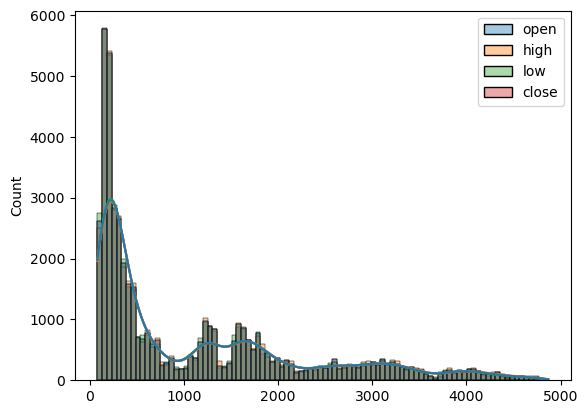

In [11]:
sns.histplot(df.select_dtypes(np.float64).iloc[:, :4], alpha=0.4, kde=True)

<Axes: xlabel='closeTime', ylabel='low'>

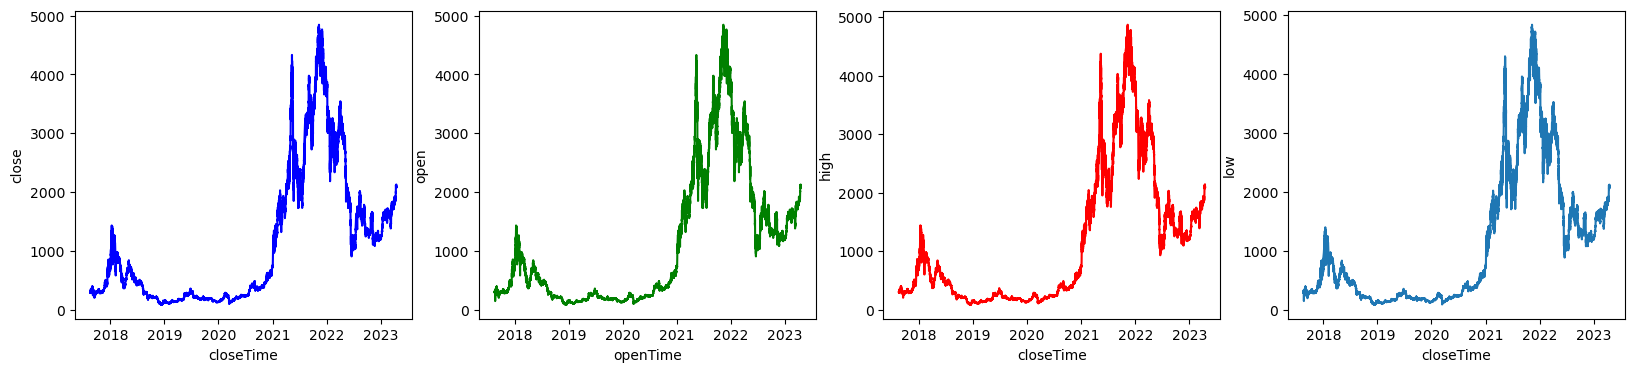

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=4, figsize=(20, 4))
sns.lineplot(x='closeTime', y='close', data=df, ax=axs[0], color='b')
sns.lineplot(x='openTime', y='open', data=df, ax=axs[1], color='g')
sns.lineplot(x='closeTime', y='high', data=df, ax=axs[2], color='r')
sns.lineplot(x='closeTime', y='low', data=df, ax=axs[3])

### 4. Feature eng. and preprocessing (Pandas, numpy only)

In [13]:
df.isna().sum()

openTime                    0
open                        0
high                        0
low                         0
close                       0
volume                      0
closeTime                   0
quoteAssetVolume            0
numTrade                    0
takerBuyBaseAssetVolume     0
takerBuyQuoteAssetVolume    0
ignore                      0
dtype: int64

In [14]:
# feature engineering for date
for time_name in df.select_dtypes('datetime64').columns.values:
    df[f'{time_name}_year'] = df[time_name].dt.year
    df[f'{time_name}_month'] = df[time_name].dt.month
    # df[f'{time_name}_month_name'] = df.openTime.dt.month_name() # cat
    df[f'{time_name}_day'] = df[time_name].dt.day
    # df[f'{time_name}_dayofweek'] = df.openTime.dt.dayofweek # cat
    df[f'{time_name}_hour'] = df[time_name].dt.hour
    df[f'{time_name}_minute'] = df[time_name].dt.minute
    df[f'{time_name}_second'] = df[time_name].dt.second

In [15]:
df.head()

,openTime,open,high,low,close,volume,closeTime,quoteAssetVolume,numTrade,takerBuyBaseAssetVolume,...,openTime_day,openTime_hour,openTime_minute,openTime_second,closeTime_year,closeTime_month,closeTime_day,closeTime_hour,closeTime_minute,closeTime_second
0,2017-08-17 04:00:00,301.13,302.57,298.0,301.61,125.66877,2017-08-17 04:59:59.999000064,37684.804181,129,80.56377,...,17,4,0,0,2017,8,17,4,59,59
1,2017-08-17 05:00:00,301.61,303.28,300.0,303.10,377.67246,2017-08-17 05:59:59.999000064,114043.282676,202,328.10428,...,17,5,0,0,2017,8,17,5,59,59
2,2017-08-17 06:00:00,302.40,304.44,301.9,302.68,303.86672,2017-08-17 06:59:59.999000064,92034.441294,182,259.28668,...,17,6,0,0,2017,8,17,6,59,59
3,2017-08-17 07:00:00,302.68,307.96,302.6,307.96,754.74510,2017-08-17 07:59:59.999000064,229725.136967,198,592.43176,...,17,7,0,0,2017,8,17,7,59,59
4,2017-08-17 08:00:00,307.95,309.97,307.0,308.62,150.75029,2017-08-17 08:59:59.999000064,46559.462371,182,140.68470,...,17,8,0,0,2017,8,17,8,59,59


In [16]:
# cyclic features
def encode(data, col, max_val):
    data[f'{col}_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[f'{col}_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data


df_cyclic = encode(df, 'openTime_month', 12)
df_cyclic = encode(df_cyclic, 'closeTime_month', 12)

df_cyclic = encode(df_cyclic, 'openTime_day', 31)
df_cyclic = encode(df_cyclic, 'closeTime_day', 31)

df_cyclic = encode(df_cyclic, 'openTime_hour', 23)
df_cyclic = encode(df_cyclic, 'closeTime_hour', 23)

df_cyclic = encode(df_cyclic, 'closeTime_minute', 59)

df_cyclic = encode(df_cyclic, 'closeTime_second', 59)

In [17]:
df_cyclic.head()

,openTime,open,high,low,close,volume,closeTime,quoteAssetVolume,numTrade,takerBuyBaseAssetVolume,...,closeTime_day_sin,closeTime_day_cos,openTime_hour_sin,openTime_hour_cos,closeTime_hour_sin,closeTime_hour_cos,closeTime_minute_sin,closeTime_minute_cos,closeTime_second_sin,closeTime_second_cos
0,2017-08-17 04:00:00,301.13,302.57,298.0,301.61,125.66877,2017-08-17 04:59:59.999000064,37684.804181,129,80.56377,...,-0.299363,-0.954139,0.887885,0.460065,0.887885,0.460065,-2.449294e-16,1.0,-2.449294e-16,1.0
1,2017-08-17 05:00:00,301.61,303.28,300.0,303.10,377.67246,2017-08-17 05:59:59.999000064,114043.282676,202,328.10428,...,-0.299363,-0.954139,0.979084,0.203456,0.979084,0.203456,-2.449294e-16,1.0,-2.449294e-16,1.0
2,2017-08-17 06:00:00,302.40,304.44,301.9,302.68,303.86672,2017-08-17 06:59:59.999000064,92034.441294,182,259.28668,...,-0.299363,-0.954139,0.997669,-0.068242,0.997669,-0.068242,-2.449294e-16,1.0,-2.449294e-16,1.0
3,2017-08-17 07:00:00,302.68,307.96,302.6,307.96,754.74510,2017-08-17 07:59:59.999000064,229725.136967,198,592.43176,...,-0.299363,-0.954139,0.942261,-0.334880,0.942261,-0.334880,-2.449294e-16,1.0,-2.449294e-16,1.0
4,2017-08-17 08:00:00,307.95,309.97,307.0,308.62,150.75029,2017-08-17 08:59:59.999000064,46559.462371,182,140.68470,...,-0.299363,-0.954139,0.816970,-0.576680,0.816970,-0.576680,-2.449294e-16,1.0,-2.449294e-16,1.0


In [18]:
df_cyclic.columns

Index(['openTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime',
       'quoteAssetVolume', 'numTrade', 'takerBuyBaseAssetVolume',
       'takerBuyQuoteAssetVolume', 'ignore', 'openTime_year', 'openTime_month',
       'openTime_day', 'openTime_hour', 'openTime_minute', 'openTime_second',
       'closeTime_year', 'closeTime_month', 'closeTime_day', 'closeTime_hour',
       'closeTime_minute', 'closeTime_second', 'openTime_month_sin',
       'openTime_month_cos', 'closeTime_month_sin', 'closeTime_month_cos',
       'openTime_day_sin', 'openTime_day_cos', 'closeTime_day_sin',
       'closeTime_day_cos', 'openTime_hour_sin', 'openTime_hour_cos',
       'closeTime_hour_sin', 'closeTime_hour_cos', 'closeTime_minute_sin',
       'closeTime_minute_cos', 'closeTime_second_sin', 'closeTime_second_cos'],
      dtype='object')

In [19]:
features_list = ['open', 'high', 'low', 'close', 'volume',
                 'quoteAssetVolume', 'numTrade', 'takerBuyBaseAssetVolume',
                 'takerBuyQuoteAssetVolume', 'openTime_year', #'openTime_month',
                 'openTime_day', 'closeTime_year', 
                'closeTime_month', 'closeTime_day','closeTime_hour',
                #  'openTime_hour', 'openTime_minute', 'openTime_second',
                #  'closeTime_minute', 'closeTime_second', 
                 'openTime_day_sin',
                 'openTime_day_cos', 'openTime_month_sin', 'openTime_month_cos',
                 'closeTime_month_sin', 'closeTime_month_cos', 'closeTime_day_sin',
                 'closeTime_day_cos', 'openTime_hour_sin', 'openTime_hour_cos',
                 'closeTime_hour_sin', 'closeTime_hour_cos', 'closeTime_minute_sin',
                 'closeTime_minute_cos', 'closeTime_second_sin', 'closeTime_second_cos'
                 ]
data = df_cyclic[features_list]

### 5. Scaling, train test split (Numpy only)

In [66]:
# y_data = data['close']
# X_data = data.drop(columns='close')

In [67]:
# TRAIN_SPLIT = 40000

# X_data_train = X_data.values[:TRAIN_SPLIT]
# y_data_train = y_data.values[:TRAIN_SPLIT]
# X_data_test = X_data.values[TRAIN_SPLIT:]
# y_data_test = y_data.values[TRAIN_SPLIT:]

In [68]:
# stds_x = np.std(X_data_train, axis=0)
# means_x = np.mean(X_data_train, axis=0)
# stds_y = np.std(y_data_train, axis=0)
# means_y = np.mean(y_data_train, axis=0)

# # standard scaler (a-means)/stds
# X_data_train = (X_data_train - means_x) / stds_x
# X_data_train[np.isnan(X_data_train)] = 0    # fill na to 0
# y_data_train = (y_data_train - means_y) / stds_y
# X_data_test = (X_data_test - means_x) / stds_x
# X_data_test[np.isnan(X_data_test)] = 0    # fill na to 0
# y_data_test = (y_data_test - means_y) / stds_y

### 6. Model training

# TUT

In [69]:
data.iloc[:, 3]

0         301.61
1         303.10
2         302.68
3         307.96
4         308.62
          ...   
49538    2078.04
49539    2071.45
49540    2080.55
49541    2080.77
49542    2083.47
Name: close, Length: 49543, dtype: float64

In [20]:
TRAIN_SPLIT = 40000

In [21]:
dataset = data.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [22]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in tqdm(range(start_index, end_index)):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [23]:
dataset.shape

(49543, 31)

In [24]:
past_history = 24*5 # last 5 days
future_target = 1   # next hour
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset=dataset, target=dataset[:, 3], start_index=0,
                                                   end_index=TRAIN_SPLIT, history_size=past_history,
                                                   target_size=future_target, step=STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 3],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

  0%|          | 0/39880 [00:00<?, ?it/s]

  0%|          | 0/9422 [00:00<?, ?it/s]

In [25]:
print(x_train_single.shape)
print(y_train_single.shape)

(39880, 120, 31)
(39880,)


In [26]:
x_val_single.shape

(9422, 120, 31)

In [27]:
import tensorflow as tf

In [28]:
BATCH_SIZE = 256
BUFFER_SIZE = 39880 # 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [29]:
x_train_single.shape[0]

39880

In [30]:
data.shape[0]

49543

In [31]:
train_data_single.element_spec[0].shape

TensorShape([None, 120, 31])

In [32]:
for ex in train_data_single.take(2):
    print(f'{ex[0].shape}')
    print(f'{ex[1].shape}')

(256, 120, 31)
(256,)
(256, 120, 31)
(256,)


In [87]:
# # baseline
# single_step_model = tf.keras.models.Sequential()
# single_step_model.add(tf.keras.layers.LSTM(10,
#                                            input_shape=x_train_single.shape[-2:]))
# single_step_model.add(tf.keras.layers.Dense(1))

# single_step_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
# single_step_model.summary()

In [88]:
# single_step_model = tf.keras.models.Sequential()
# single_step_model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=x_train_single.shape[-2:]))
# # single_step_model.add(tf.keras.layers.Dropout(0.5))
# single_step_model.add(tf.keras.layers.LSTM(50, return_sequences=True))
# # single_step_model.add(tf.keras.layers.Dropout(0.5))
# single_step_model.add(tf.keras.layers.LSTM(30))
# single_step_model.add(tf.keras.layers.Dense(1))

# single_step_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
# single_step_model.summary()

In [90]:
# inputs = tf.keras.Input(120, 28)
# embedding = tf.keras.layers.Embedding(512, 64, input_length=1024)(inputs)
# bidirectional1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedding)
# bidirectional2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedding)

# # merge layers
# merged_layers = tf.keras.layers.concatenate([bidirectional1, bidirectional2])

# dense1 = tf.keras.layers.Dense(32, activation='relu')(merged_layers)
# outputs = tf.keras.layers.Dense(1)(dense1)
# single_step_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="lstm_model")
# # tf.keras.utils.plot_model(model, "model.png",show_shapes=True)
# single_step_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
# single_step_model.summary()

### LSTM

In [34]:
# best epoches=2-10 val loss 0.0017

inputs = tf.keras.Input(x_train_single.shape[-2:])
# embedding = tf.keras.layers.Embedding(28, 256, input_length=28)(inputs)
# bidirectional2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(embedding)
# bidirectional1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences=True, input_shape=x_train_single.shape[-2:]))(inputs)
bidirectional1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, ))(inputs)
bidirectional1 = tf.keras.layers.LSTM(256, return_sequences=True)(bidirectional1)
bidirectional2 = tf.keras.layers.LSTM(256, return_sequences=True)(inputs)
# bidirectional1 = tf.keras.layers.LSTM(32)(bidirectional1)

# merge layers
merged_layers = tf.keras.layers.concatenate([bidirectional1, bidirectional2])

bidirectional12 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, ))(merged_layers)
bidirectional12 = tf.keras.layers.LSTM(128, )(bidirectional12)
bidirectional22 = tf.keras.layers.LSTM(128, )(merged_layers)

merged_layers2 = tf.keras.layers.add([bidirectional12, bidirectional22])
# merged_layers = tf.keras.layers.Dense(16)(merged_layers) #(dense1)
outputs = tf.keras.layers.Dense(1)(merged_layers2) #(dense1)
single_step_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="lstm_model")
tf.keras.utils.plot_model(single_step_model, "model.png",show_shapes=True)
single_step_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
single_step_model.summary()

Model: "lstm_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 31)]    0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 120, 512)     589824      input_2[0][0]                    
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 120, 256)     787456      bidirectional_2[0][0]            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 120, 256)     294912      input_2[0][0]                    
_________________________________________________________________________________________

In [36]:
EPOCHS = 4
EVALUATION_INTERVAL = x_train_single.shape[0] // BATCH_SIZE # 2000
VAL_STEPS = x_val_single.shape[0] // BATCH_SIZE # 500

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=VAL_STEPS,
                                            shuffle=False)

Epoch 1/4
155/155 [==============================] - 61s 327ms/step - loss: 0.0261 - val_loss: 0.0038
Epoch 2/4
155/155 [==============================] - 47s 302ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 3/4
155/155 [==============================] - 48s 308ms/step - loss: 9.5077e-04 - val_loss: 0.0057
Epoch 4/4
155/155 [==============================] - 48s 312ms/step - loss: 0.0010 - val_loss: 0.0046


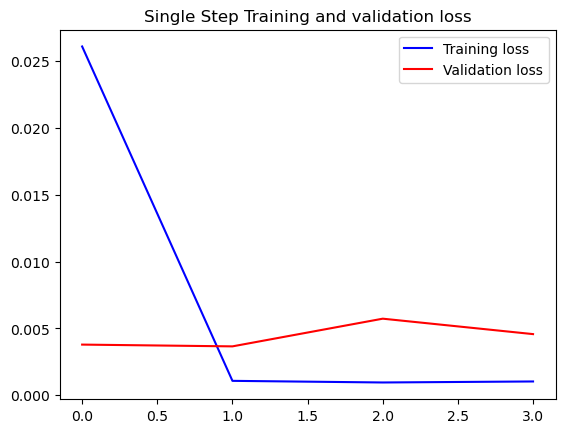

In [37]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [38]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'LSTM Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    plt.ylabel('close')
    return plt

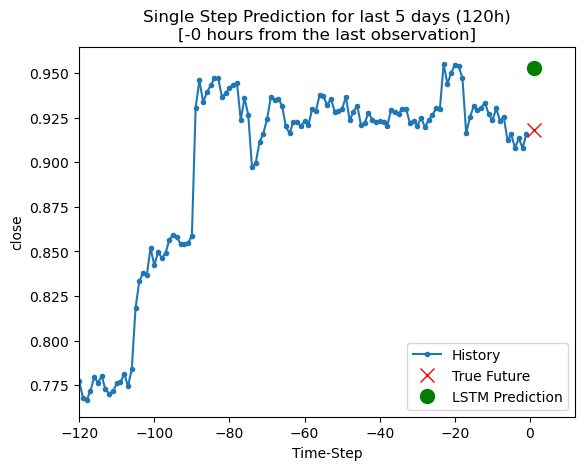

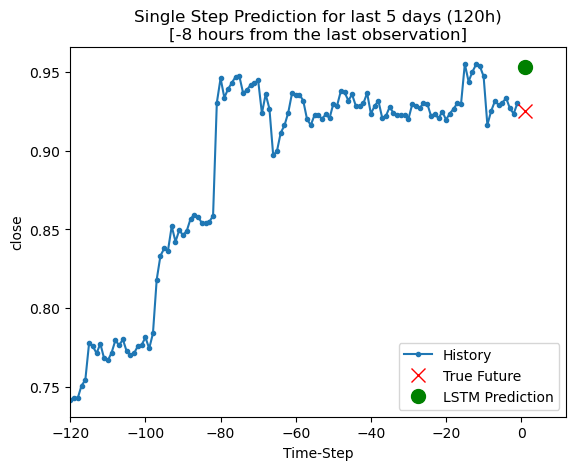

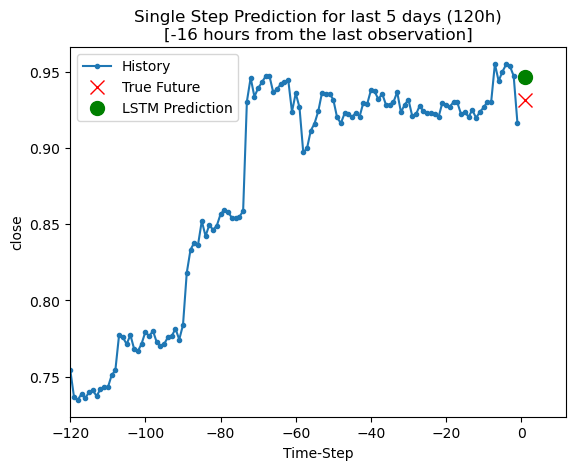

In [39]:
for i in range(0, 20, 8):
    plot = show_plot([x_val_single[-(i+1)][:, 3], y_val_single[-(i+1)],
                    single_step_model.predict(np.array([x_val_single[-(i+1)]]))], 1,
                    f'Single Step Prediction for last 5 days (120h)\n[-{i} hours from the last observation]')
    plot.show()

(256, 120, 31)
(256,)


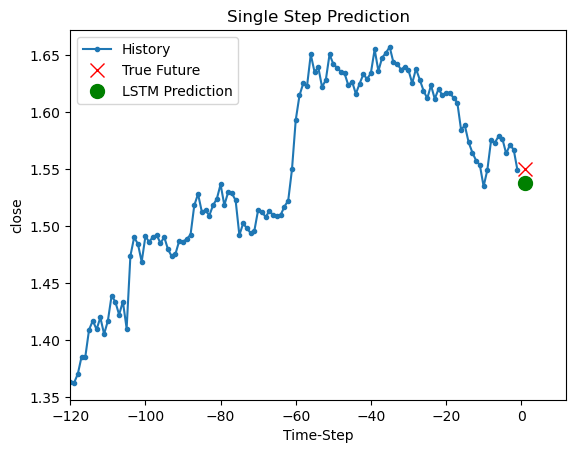

(256, 120, 31)
(256,)


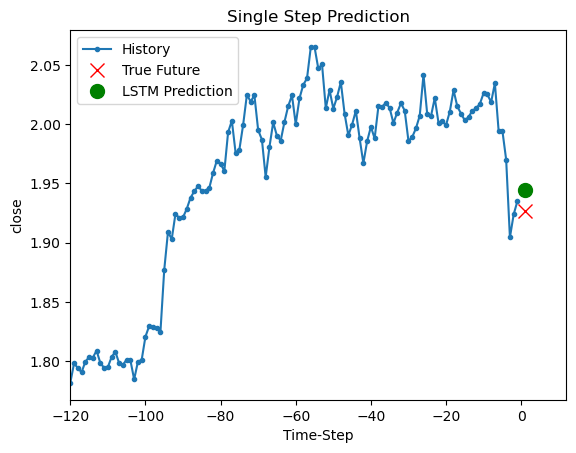

(256, 120, 31)
(256,)


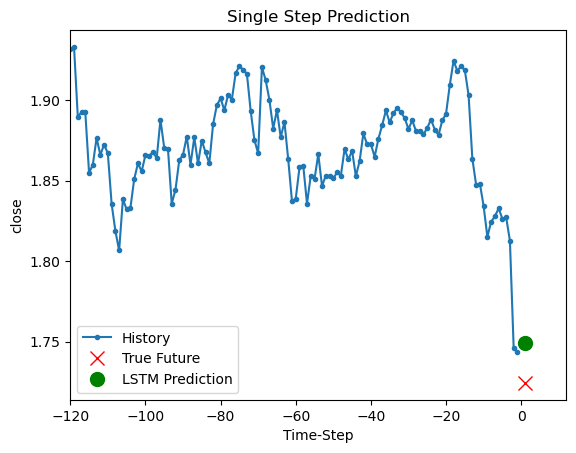

(256, 120, 31)
(256,)


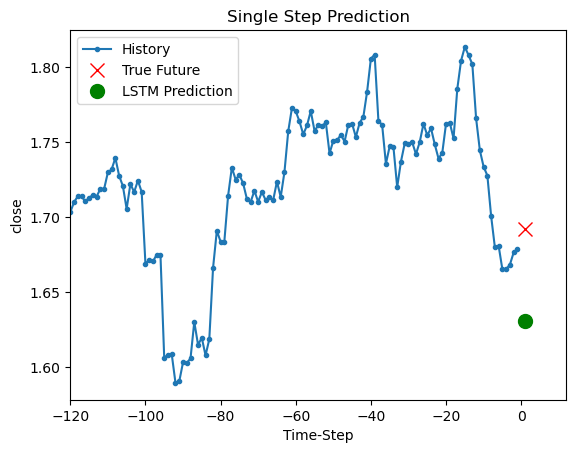

(256, 120, 31)
(256,)


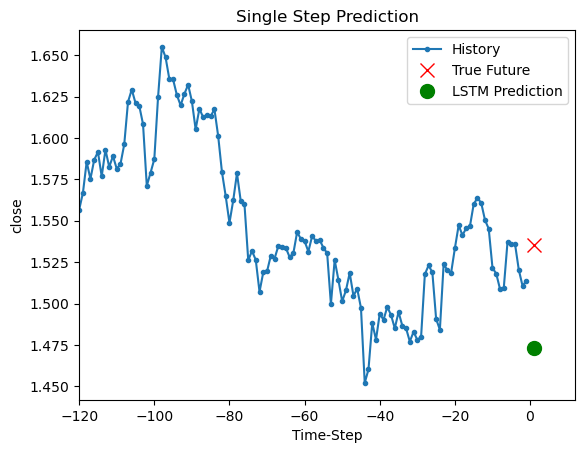

(256, 120, 31)
(256,)


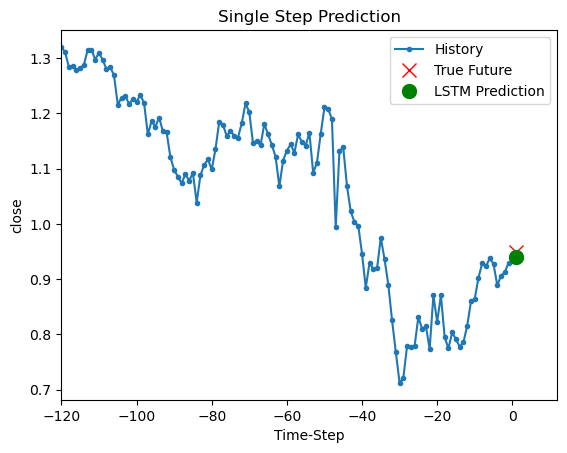

(256, 120, 31)
(256,)


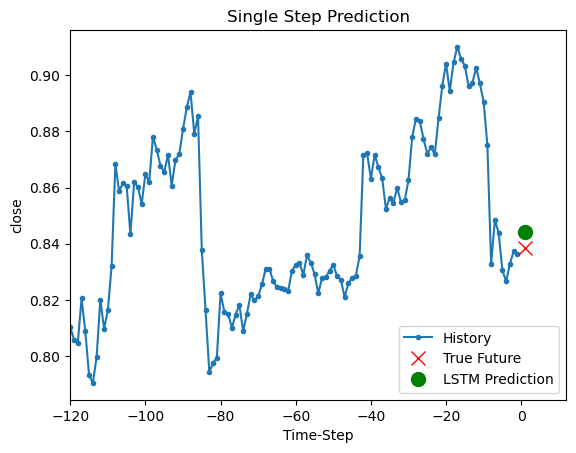

(256, 120, 31)
(256,)


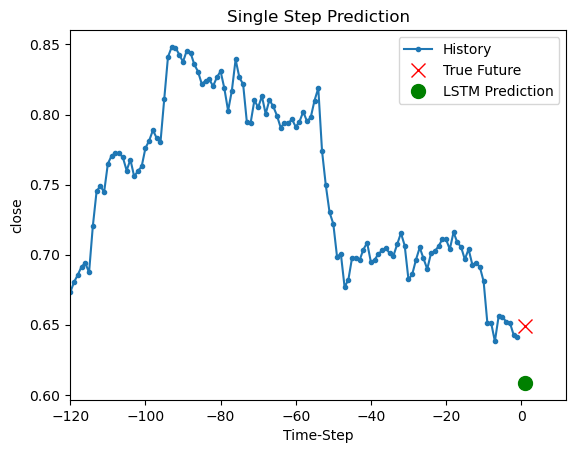

(256, 120, 31)
(256,)


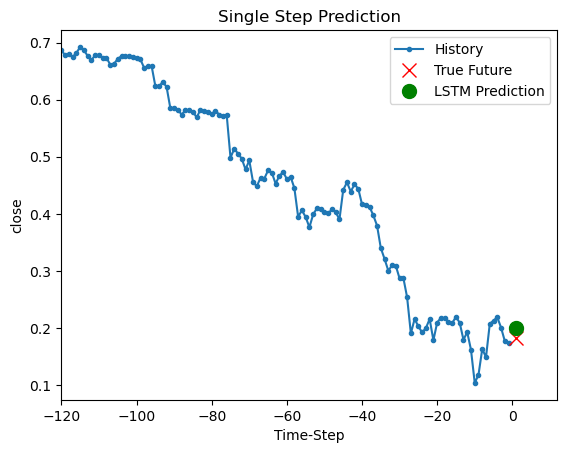

(256, 120, 31)
(256,)


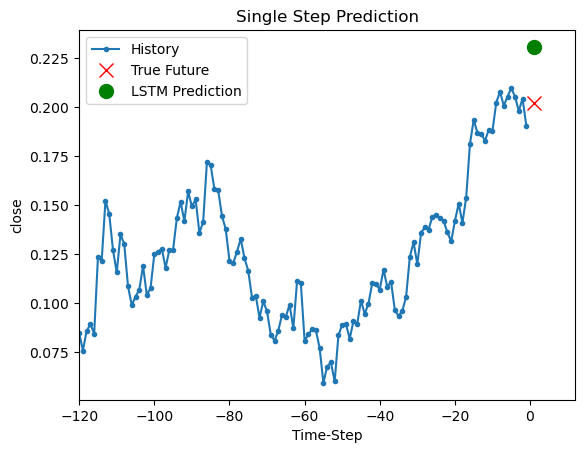

In [40]:
el = 0
for x, y in val_data_single.take(10):
    print(x[:].shape)
    print(y[:].shape)
    plot = show_plot([x[el][:, 3].numpy(), y[el].numpy(),
                    single_step_model.predict(x)[el]], 1,
                    'Single Step Prediction')
    plot.show()

In [163]:
def download_save_klines(history_range: int=50, limit_param: int=1000, save: bool=True) -> pd:
    base = 'https://api.binance.com'    # 'https://fapi.binance.com'
    req = '/api/v3/klines'  # '/fapi/v1/klines'
    url = base + req

    # current time
    date_time = datetime.datetime.now()
    unix_date_end = 1000*int(time.mktime(date_time.timetuple()))

    end_time = unix_date_end
    df = pd.DataFrame([])
    for _ in tqdm(range(history_range), desc='Total'):
        params = {'symbol': 'ETHUSDT',
                    'interval': '1h',
                    'endTime': end_time,
                    'limit': limit_param}

        r = requests.get(url, params=params)
        if r.status_code == 200:
            # w take a data packet for the previous time period
            end_time = r.json()[0][0] - 3600 * 1000
        else:
            print(r.json())
        df = pd.concat([pd.DataFrame(r.json()), df])
        
    df.columns = ['openTime', 'open', 'high', 'low', 'close', 'volume',
                    'closeTime', 'quoteAssetVolume', 'numTrade', 'takerBuyBaseAssetVolume',
                    'takerBuyQuoteAssetVolume', 'ignore']
    df = df.reset_index(drop=True)
    if save:
        df.to_csv('data/klines_2.csv', index=False)
    return df

def preprocess_data(df: pd) -> pd:
    # convert time data
    df['openTime'] = pd.to_datetime(df['openTime']/1000, unit='s')
    df['closeTime'] = pd.to_datetime(df['closeTime']/1000, unit='s')
    # convert to float
    obj_to_float_list = df.select_dtypes(object).columns
    df[obj_to_float_list] = df[obj_to_float_list].astype(np.float64)
    return df

def feature_engineering(df: pd) -> pd:
    # feature engineering for date
    for time_name in df.select_dtypes('datetime64').columns.values:
        df[f'{time_name}_year'] = df[time_name].dt.year
        df[f'{time_name}_month'] = df[time_name].dt.month
        df[f'{time_name}_day'] = df[time_name].dt.day
        df[f'{time_name}_hour'] = df[time_name].dt.hour
        df[f'{time_name}_minute'] = df[time_name].dt.minute
        df[f'{time_name}_second'] = df[time_name].dt.second

    # cyclic features
    def encode(data, col, max_val):
        data[f'{col}_sin'] = np.sin(2 * np.pi * data[col]/max_val)
        data[f'{col}_cos'] = np.cos(2 * np.pi * data[col]/max_val)
        return data


    df_cyclic = encode(df, 'openTime_month', 12)
    df_cyclic = encode(df_cyclic, 'closeTime_month', 12)
    df_cyclic = encode(df_cyclic, 'openTime_day', 31)
    df_cyclic = encode(df_cyclic, 'closeTime_day', 31)
    df_cyclic = encode(df_cyclic, 'openTime_hour', 23)
    df_cyclic = encode(df_cyclic, 'closeTime_hour', 23)
    df_cyclic = encode(df_cyclic, 'closeTime_minute', 59)
    df_cyclic = encode(df_cyclic, 'closeTime_second', 59)

    features_list = ['open', 'high', 'low', 'close', 'volume',
                 'quoteAssetVolume', 'numTrade', 'takerBuyBaseAssetVolume',
                 'takerBuyQuoteAssetVolume', 'openTime_year', #'openTime_month',
                 'openTime_day', 'closeTime_year', 
                'closeTime_month', 'closeTime_day','closeTime_hour',
                #  'openTime_hour', 'openTime_minute', 'openTime_second',
                #  'closeTime_minute', 'closeTime_second', 
                 'openTime_day_sin',
                 'openTime_day_cos', 'openTime_month_sin', 'openTime_month_cos',
                 'closeTime_month_sin', 'closeTime_month_cos', 'closeTime_day_sin',
                 'closeTime_day_cos', 'openTime_hour_sin', 'openTime_hour_cos',
                 'closeTime_hour_sin', 'closeTime_hour_cos', 'closeTime_minute_sin',
                 'closeTime_minute_cos', 'closeTime_second_sin', 'closeTime_second_cos'
                 ]
    return df_cyclic[features_list]

In [164]:
import datetime
import time
df = download_save_klines(history_range=1, limit_param=120, save=False)

Total:   0%|          | 0/1 [00:00<?, ?it/s]

In [165]:
df_last = feature_engineering(preprocess_data(download_save_klines(history_range=1, limit_param=120, save=False))).values

Total:   0%|          | 0/1 [00:00<?, ?it/s]

In [172]:
single_step_model.predict(np.array([df_last]))[0][0]

0.41440588